Deceleration of electrons:
Bethe Law is used to calculate the average energy loss,

##### The PAP calculation is performed in two steps:
* Calculation of the area of the distribution, equivalent in principle to that of an atomic number correction
* Direct calculation of the generated intensity, on the basis for the distribution phi(rho.z) which is defined by its area and by the parameters of form adapted to the selected mathematical representation

In [7]:
import math
import pandas as pd
import numpy as np
import sqlite3
import ZAF as zaf
# plotting
import matplotlib.pyplot as plt
# inputs
elements = ['Fe','Ni']
elements_df = zaf.get_element(elements)
C = {'Fe':0.1, 'Ni':0.9}
Ec = {'Fe': 7.11, 'Ni': 8.332} ### Check if you have to add all the lines and what to put for H
E = 15 # in keV
# import the constants
A = elements_df[['element','molar_mass']]
Z = elements_df[['element','atomic_number']]
density = elements_df[['element','density']]
# import MAC
mac = zaf.get_mac(elements, file_mac='Henke 1993_modified.txt')
print(Z[Z['element'] == 'Fe'])

  element  atomic_number
0      Fe             26


In [8]:
# area parameter (number of primary ionizations)
#1 deceleration of electrons
def f(E,J):
    res = 0
    Dk = [6.6*pow(10,-6), 1.12*pow(10,-5)*(1.35-0.45*pow(J,2)), 2.2*pow(10,-6)/J]
    Pk = [0.78, 0.1, -(0.5-0.25*J)]
    for i in range(3):
        res += Dk[i]*(E/J)*pow(E/J, Pk[i])
    return res
def dE_dps_calc(E,C,Z,A):
    lnJ = 0
    M = 0
    # M
    for element in elements:
        z_element = Z[Z['element'] == element].atomic_number.values
        a_element = A[A['element'] == element].molar_mass.values
        M += C[element] * z_element/a_element
    # Ji, J
    for element in elements: 
        z_element = Z[Z['element'] == element].atomic_number.values
        a_element = A[A['element'] == element].molar_mass.values
        Ji = pow(10,-3) * z_element *(10.04 + 8.25 * math.exp(-z_element/11.22)) # in keV
        lnJi = math.log(Ji)
        lnJ += (C[element]*(z_element/a_element)*lnJi)/M
    J = math.exp(lnJ) # in keV
    V = E/J
    # Ro
    Dk = [6.6*pow(10,-6), 1.12*pow(10,-5)*(1.35-0.45*pow(J,2)), 2.2*pow(10,-6)/J]
    Pk = [0.78, 0.1, -(0.5-0.25*J)]
    Ro = 0
    for i in range(3):
        Ro += (1/M)*(pow(J,1-Pk[i])*Dk[i]*pow(E,1+Pk[i])/(1+Pk[i]))
    dE_dps = -(M/J)*[1/f(E,J)] # keV.g-1.cm2
    return dE_dps,V,J,M,Ro
# calculate the deceleration
dE_dps,V,J,M,Ro = dE_dps_calc(E,C,Z,A)

print("[+] dE/dps: ", dE_dps)
print("[+] V: ", V)
print("[+] J: ", J)
print("[+] M: ", M)
print("[+] Ro [g/cm2]: ", Ro)

[+] dE/dps:  [-194.34381608]
[+] V:  50.275346541764314
[+] J:  0.2983569688085457
[+] M:  [0.47590724]
[+] Ro [g/cm2]:  [0.0009488]


In [9]:
# Ionization cross section
inverse_S = 0
#input
excited_element = 'Fe'
excited_line = 'K'
# calculating 1/S
Uo = E/Ec[excited_element]
Vo = V #### IS THIS TRUE???? ####
k = [6.6*pow(10,-6), 1.12*pow(10,-5)*(1.35-0.45*pow(J,2)), 2.2*pow(10,-6)/J]
Pk = [0.78, 0.1, -(0.5-0.25*J)]
m_k=0.86 + 0.12 * math.exp(-pow((Z[Z['element'] == excited_element].atomic_number.values)/5, 2))
m_values= {'K': m_k,
    'L': 0.82,
    'M': 0.78}
m = m_values['K']
T = [1+Pk[0]-m, 1+Pk[1]-m, 1+Pk[2]-m]
for i in range(3):
    inverse_S += (Uo/(Vo*M)) * k[i]* pow(Vo/Uo, Pk[i]) * (T[i]*pow(Uo, T[i])*math.log(Uo)-pow(Uo,T[i])+1)/pow(T[i],2)
print("1/S: ", inverse_S)

1/S:  [3.67882138e-06]


In [10]:
# Backscatter factor R
# After calculating R/S, representing the primary intensity, and Q^A_l(Eo), one determines the area F of the distribution phi(pz):
# F = (R/S)Q

######################## Appendix I
# Z_b_bar
Z_b_bar = 0
for element in elements:
    z_element = Z[Z['element'] == element].atomic_number.values
    Z_b_bar += C[element] * pow(z_element,1/2)
Z_b_bar = pow(Z_b_bar, 2)
# eta bar
eta_bar = 1.75*pow(10,-3)*Z_b_bar + 0.37*(1-math.exp(-0.015*pow(Z_b_bar, 1.3)))
# J(Uo)
def J_func(Uo):
    J = 1+Uo*(math.log(Uo) - 1)
    return J
# G(Uo)
def G(Uo, W_bar):
    q = (2 * W_bar - 1) / (1 - W_bar)
    G = (Uo-1-(1-1/pow(Uo, 1+q))/(1+q))/((2+q)*J_func(Uo))
    return G

W_bar = 0.595 * eta_bar/3.7 + pow(eta_bar,4.55)
R = 1 - eta_bar * W_bar*(1-G(Uo,W_bar))
print("Backscatter factor R:", R)
# F
cross_section = math.log(Uo)/(pow(Uo, m)*Ec[excited_element]*Ec[excited_element])
F = (R*inverse_S) * cross_section
print('Uo:', Uo)
print('R :', R)
print('1/S: ', inverse_S)
print('Q: ',cross_section)
print('F:', F)

Backscatter factor R: [0.99641447]
Uo: 2.109704641350211
R : [0.99641447]
1/S:  [3.67882138e-06]
Q:  0.055253206266280816
F: [2.02537858e-07]


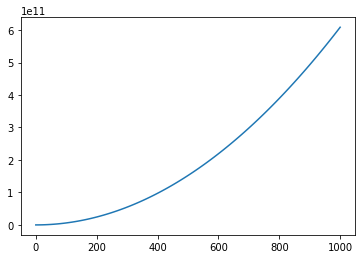

In [18]:
######## phi(rhoz)
r = 2 - 2.3 * eta_bar
# Phio
phi0 = 1 + 3.3 * (1-1/pow(Uo,r))* pow(eta_bar, 1.2)
# Z_bar_n
lnZ_bar_n = 0
for element in elements:
    z_element = Z[Z['element'] == element].atomic_number.values
    lnZ_bar_n += C[element] * math.log(z_element)
Z_bar_n = math.exp(lnZ_bar_n)

def phi(pz, phi0, Z_bar_n, M, J):
    Eo = E
    D1 = 6.6*pow(10,-6)
    D2 =1.12*pow(10,-5)*(1.35-0.45*pow(J,2))
    D3 = 2.2*pow(10,-6)/J
    Dk = [D1,D2,D3]
    Pk = [0.78, 0.1, -(0.5-0.25*J)]
    Z_bar = 0
    for element in elements:
        z_element = Z[Z['element'] == element].atomic_number.values
        Z_bar += C[element] * z_element
    
    # Rx the range of ionization
    # Ro is the total trajectory of the electrons between Eo and El
    # Q is a function of overvolatge and atomic number
    b = 40/Z_bar
    Qo = 1 - 0.535 * math.exp(-pow(21/Z_bar_n, 1.2)) - 2.5*pow(10,-4)*pow(Z_bar_n/20, 3.5)
    Q = Qo + (1-Qo)*math.exp(-(Uo-1)/b)
    # D
    h = pow(Z_bar, 0.45)
    D = 1+1/pow(Uo,h)
    # Ro
    Ro = 0
    for i in range(3):
        Ro += (1/M) * pow(J, 1-Pk[i]) * Dk[i] * (pow(Eo,1+Pk[i])-pow(Ec[excited_element], 1+Pk[i])/(1+Pk[i]))
    
    # Rx
    Rx = Q * D * Ro
    
    # Rm depth of the maximum of the distribution
    G1 = 0.11 * 0.41 * math.exp(-pow(Z_bar/12.75, 0.75))
    G2 = 1 - math.exp(-pow((Uo - 1), 0.35)/1.19)
    G3 = 1 - math.exp(-(Uo-0.5)*pow(Z_bar,0.4)/4)
    Rm = G1 * G2 * G3 * Rx
    # d
    d = (Rx-Rm)*((F-phi0*Rx/3) * ((Rx-Rm)*F - phi0*Rx*(Rm+Rx/3)))
    # Rc
    Rc = (3/2)
    Rc *= (((F - phi0*Rx/3)/phi0) - pow(d, 1/2)/(phi0*(Rx-Rm)))
    A1 = phi0 /(Rm*(Rc - Rx * (Rc/Rm - 1)))
    B1 = phi0 - A1 * Rm*Rm
    A2 = A1 * (Rc - Rm)/(Rc - Rx)
    
    if pz >=0 or pz <= Rc:
        phi = A1 * (pz - Rm) * (pz - Rm) + B1
    if pz > Rc or pz <= Rx:
        phi = A2 * (pz - Rx) * (pz - Rx)
        
    # Absorption factor 
    F1 = (A1/X)*(((Rc-Rm) * (Rx-Rc-2/X)-2/(X*X))*math.exp(-X*Rc) - (Rc-Rm)*Rx + Rm*(Rc-2/X) + 2/(X*X))
    F2 = (A2/X)*(((Rx-Rc) * (Rx-Rc-2/X)-2/(X*X))*math.exp(-X*Rc) - (2/(X*X)*math.exp(-X*Rx)))
    f_X = (F1+F2)/F
    return phi
pz = np.linspace(0,1000,100)
phi_a = []
for value in pz:
    phi_a.append(phi(value,phi0,Z_bar_n,M,J))
plt.plot(pz,phi_a)

In [ ]:
nMsEl = len(elements)
# calculating IntPAPstd in each standard
IntPAPstd = CalcI(Std_AtWtPc, Eo, MACkalpha)